# Exercise : R - Neural Networks


## Iris Dataset

In [33]:
#Import packages 
library(ggplot2, quietly=True)
library(gridExtra, quietly=True)
library(repr)
library(dplyr)
library(caret)
library(nnet)
library(MLmetrics)
install.packages('e1071', dependencies=TRUE)

#set the initial plot area dimensions
options(repr.plot.width=4, repr.plot.height=4)

also installing the dependencies ‘mlbench’, ‘randomForest’, ‘xtable’, ‘slam’




The downloaded binary packages are in
	/var/folders/kk/0_k2fzhd2w33dmwd21vb0_d80000gn/T//Rtmp8oyXja/downloaded_packages


Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


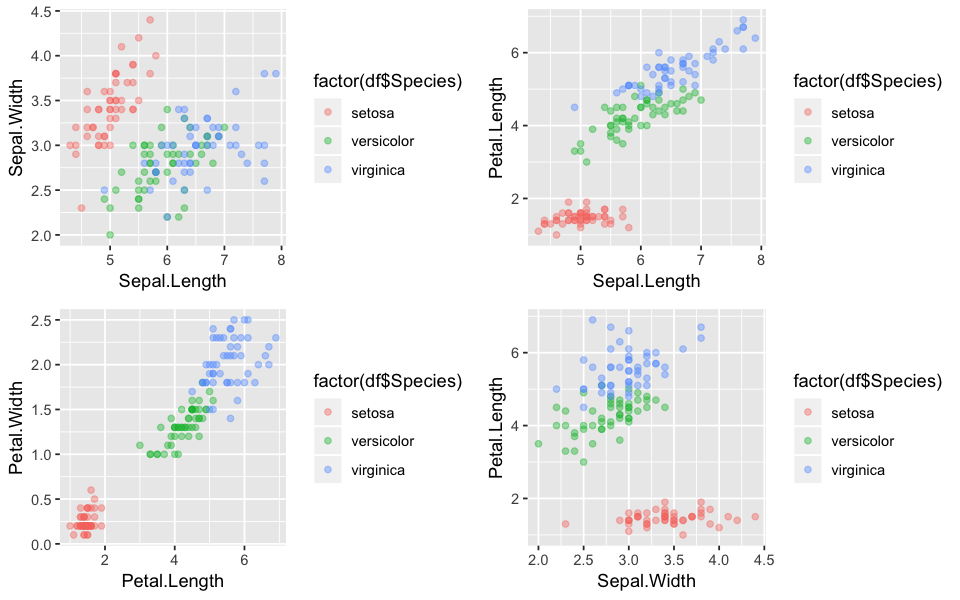

In [5]:
# load and plot data

single_plot = function(df, colx, coly){
    ggplot(df, aes_string(colx, coly)) +
    geom_point(aes(color=factor(df$Species)), alpha=0.4)
}

plot_iris = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot(df, 'Sepal.Length', 'Petal.Length'),
        single_plot(df, 'Petal.Length', 'Petal.Width'),
        single_plot(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
}
head(iris,10)
plot_iris(iris)

In [6]:
#split data into training and test
set.seed(1955)
## Randomly sample cases to create independent training and test data
partition = createDataPartition(iris[,'Species'], times=1, p=0.33, list=F)
training = iris[partition,]
dim(training)
test = iris[-partition,] # create test sample
dim(test)

[1] 51  5

[1] 99  5

In [7]:
#scale dataset for input into neural nets
num_cols = c('Sepal.Length','Sepal.Width','Petal.Length','Petal.Width')
preProcValues <- preProcess(training[,num_cols], method = c("center","scale"))

training[,num_cols] = predict(preProcValues, training[,num_cols])
test[,num_cols] = predict(preProcValues, test[,num_cols])
head(training[,num_cols])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
3,-1.2646501,0.4563512,-1.348274,-1.287390
5,-0.9016267,1.4161001,-1.293220,-1.287390
6,-0.4175955,2.1359118,-1.128059,-1.027876
9,-1.6276734,-0.2634605,-1.293220,-1.287390
10,-1.0226345,0.2164140,-1.238167,-1.417146
11,-0.4175955,1.6560373,-1.238167,-1.287390


In [27]:
# define and fit a neural network using nnet. It will have a single 
# hidden layer with 50 neurons

nn_mod = nnet(Species ~., data=training, size=c(50))

# weights:  403
initial  value 93.515320 
iter  10 value 1.906170
iter  20 value 0.007107
final  value 0.000084 
converged


In [30]:
# make predictions with model
probs = predict(nn_mod, newdata=test)
head(probs)
test$scores = apply(probs, 1, which.max)
test$scores = ifelse(test$scores == 1, 'setosa', ifelse(test$scores==2,
                                                       'versicolor',
                                                       'virginica'))
head(test)

,setosa,versicolor,virginica
1,1,7.949008e-10,3.747533e-52
2,1,2.099909e-09,5.037809e-52
4,1,1.093013e-09,5.737094e-51
7,1,1.302964e-09,9.793011e-51
8,1,7.277835e-10,5.403120e-52
12,1,9.141533e-10,2.149432e-51


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species,scores
1,-0.7806189,1.17616289,-1.293220,-1.287390,setosa,setosa
2,-1.0226345,-0.02352326,-1.293220,-1.287390,setosa,setosa
4,-1.3856579,0.21641397,-1.238167,-1.287390,setosa,setosa
7,-1.3856579,0.93622566,-1.293220,-1.157633,setosa,setosa
8,-0.9016267,0.93622566,-1.238167,-1.287390,setosa,setosa
12,-1.1436423,0.93622566,-1.183113,-1.287390,setosa,setosa


In [31]:
print_metrics = function(df, label){
    # compute and print the confusion matrix
    cm = as.matrix(table(Actual = df$Species, Predicted = df$scores))
    print(cm)
    
    # compute and print accuracy
    accuracy = round(sum(sapply(1:nrow(cm), function(i) cm[i,i]))/sum(cm),3)
    cat('\n')
    cat(paste('Accuracy = ', as.character(accuracy)),'\n \n')
    
    # compute and print precision, recall and F1
    precision = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[i,]))
    recall = sapply(1:nrow(cm), function(i) cm[i,i]/sum(cm[,i]))
    F1 = sapply(1:nrow(cm), function(i) 2*(recall[i] * precision[i])/(recall[i] + precision[i]))
    metrics = sapply(c(precision, recall, F1), round, 3)
    metrics = t(matrix(metrics,nrow=nrow(cm), ncol=ncol(cm)))
    dimnames(metrics) = list(c('Precision','Recall','F1'),unique(test$Species))
    print(metrics)
}
print_metrics(test, 'Species')

            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         30         3
  virginica       0          6        27

Accuracy =  0.909 
 
          setosa versicolor virginica
Precision      1      0.909     0.818
Recall         1      0.833     0.900
F1             1      0.870     0.857


In [34]:
#check importance of features
set.seed(9876)
trControl <- trainControl(method='cv', number=10)

nn_mod_train = train(Species ~.,
                    data=training,
                    method="nnet",
                    verbose=F,
                    trControl=trControl,
                    tuneGrid = expand.grid(decay=0, size=c(50)),
                    trace=F)
nn_mod_train

Neural Network 

51 samples
 4 predictor
 3 classes: 'setosa', 'versicolor', 'virginica' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 47, 46, 46, 45, 46, 45, ... 
Resampling results:

  Accuracy   Kappa    
  0.8983333  0.8425579

Tuning parameter 'size' was held constant at a value of 50
Tuning
 parameter 'decay' was held constant at a value of 0

In [35]:
# display importance
options(repr.plot.width=4, repr.plot.height=3)
imp = varImp(nn_mod_train, scale=F)$importance
imp

,Overall,setosa,versicolor,virginica
Sepal.Length,16.31944,16.31944,16.31944,16.31944
Sepal.Width,20.27989,20.27989,20.27989,20.27989
Petal.Length,38.09340,38.09340,38.09340,38.09340
Petal.Width,25.30727,25.30727,25.30727,25.30727


In [38]:
# Train and evaluate a model using the most important features
set.seed(5678)
nn_mod = nnet(Species ~ Sepal.Width + Petal.Length + Petal.Width, data=training,
             size=c(50))
probs = predict(nn_mod, newdata=test)
test$scores = apply(probs, 1, which.max)
test$scores = ifelse(test$scores == 1, 'setosa', ifelse(test$scores == 2,
                                                       'versicolor',
                                                       'virginica'))
print_metrics(test, 'Species')

# weights:  353
initial  value 63.510365 
iter  10 value 2.019559
iter  20 value 0.020646
final  value 0.000092 
converged
            Predicted
Actual       setosa versicolor virginica
  setosa         33          0         0
  versicolor      0         30         3
  virginica       0          6        27

Accuracy =  0.909 
 
          setosa versicolor virginica
Precision      1      0.909     0.818
Recall         1      0.833     0.900
F1             1      0.870     0.857


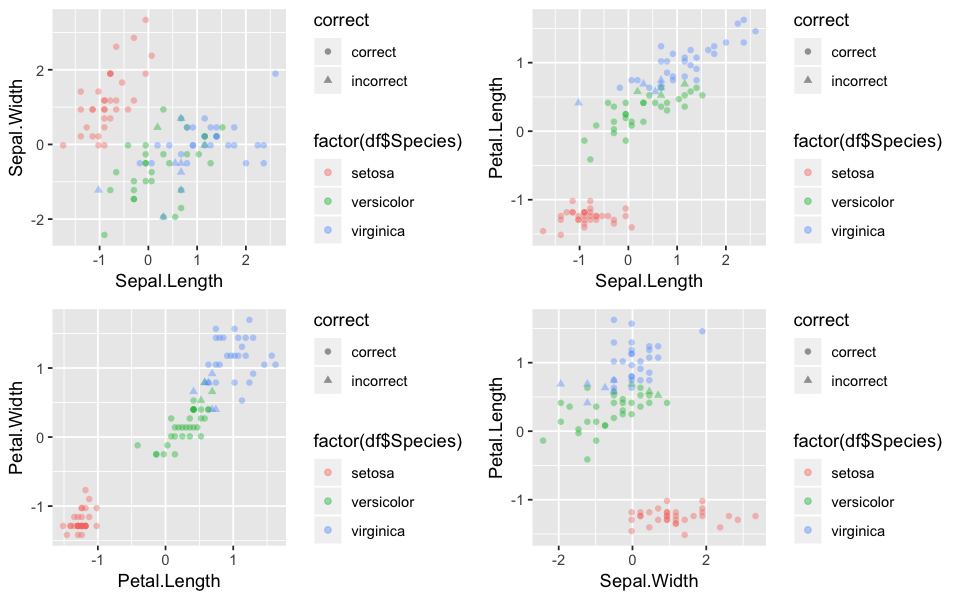

In [39]:
# create column of correct-incorrect classification
test$correct = ifelse(test$Species == test$scores, 'correct', 'incorrect')

single_plot_classes = function(df, colx, coly){
    ggplot(df, aes_string(colx, coly)) +
    geom_point(aes(color = factor(df$Species), shape=correct), alpha=0.4)
}

plot_iris_classes = function(df){
    options(repr.plot.width=8, repr.plot.height=5)
    grid.arrange(
        single_plot_classes(df, 'Sepal.Length', 'Sepal.Width'),
        single_plot_classes(df, 'Sepal.Length', 'Petal.Length'),
        single_plot_classes(df, 'Petal.Length', 'Petal.Width'),
        single_plot_classes(df, 'Sepal.Width', 'Petal.Length'),
        nrow = 2)
    }

plot_iris_classes(test)